# Shreya Sapkota  
# MSCS 634 – Advanced Big Data and Data Mining  
# Lab 2: Clustering Analysis Using K-Means and K-Medoids Algorithms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

# Load dataset
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names

# Basic exploration
print("Feature names:", feature_names)
print("Shape of data:", X.shape)
print("Class distribution:", np.bincount(y))

# Standardize features using z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Shape of data: (178, 13)
Class distribution: [59 71 48]


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Performance metrics
sil_score_kmeans = silhouette_score(X_scaled, kmeans_labels)
ari_kmeans = adjusted_rand_score(y, kmeans_labels)

print(f"K-Means Silhouette Score: {sil_score_kmeans:.3f}")
print(f"K-Means Adjusted Rand Index: {ari_kmeans:.3f}")


K-Means Silhouette Score: 0.285
K-Means Adjusted Rand Index: 0.897


In [9]:
!pip install pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395196 sha256=d5ccd493b34fbdb025572fc13edcff196bdb4143a0de3608db38c72fe8d81673
  Stored in directory: /Users/shreya/Library/Caches/pip/wheels/9f/99/15/e881f46a92690ae77c2e3b255b89ea45d3a867b1b6c2ab3ba9
Successfully built pyclustering


In [10]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix
from sklearn.metrics import silhouette_score, adjusted_rand_score
import random

# Pick 3 initial medoid indices at random
initial_medoids = random.sample(range(len(X_scaled)), 3)

# Distance matrix is required by pyclustering
distance_matrix = calculate_distance_matrix(X_scaled)

# Run K-Medoids
kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()

clusters = kmedoids_instance.get_clusters()
medoid_indices = kmedoids_instance.get_medoids()

# Flatten cluster labels
kmedoids_labels = np.empty(len(X_scaled))
for cluster_id, cluster in enumerate(clusters):
    for index in cluster:
        kmedoids_labels[index] = cluster_id

# Metrics
sil_score_kmedoids = silhouette_score(X_scaled, kmedoids_labels)
ari_kmedoids = adjusted_rand_score(y, kmedoids_labels)

print(f"K-Medoids (pyclustering) Silhouette Score: {sil_score_kmedoids:.3f}")
print(f"K-Medoids (pyclustering) Adjusted Rand Index: {ari_kmedoids:.3f}")


K-Medoids (pyclustering) Silhouette Score: 0.266
K-Medoids (pyclustering) Adjusted Rand Index: 0.726


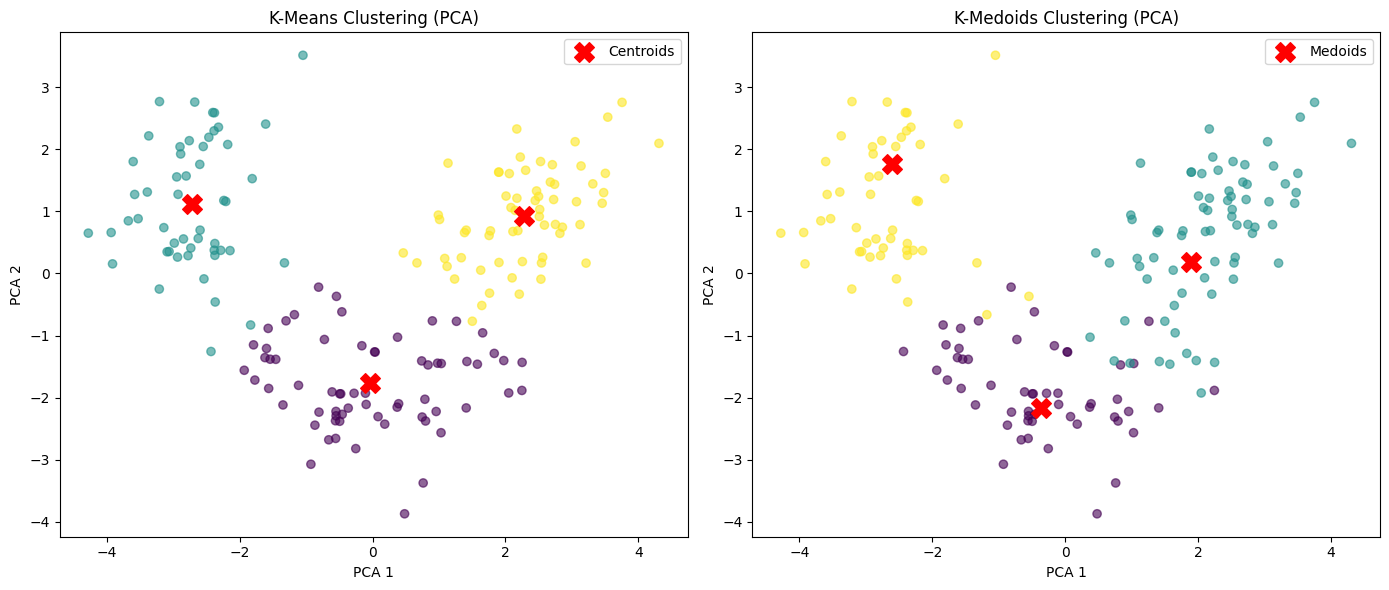

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce data to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get medoid indices from pyclustering
medoid_indices = kmedoids_instance.get_medoids()
medoids_pca = pca.transform(X_scaled[medoid_indices])

# Get KMeans centroids and transform to PCA space
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Set up plot
plt.figure(figsize=(14, 6))

# --- K-Means Plot ---
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.title('K-Means Clustering (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

# --- K-Medoids Plot ---
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmedoids_labels, cmap='viridis', alpha=0.6)
plt.scatter(medoids_pca[:, 0], medoids_pca[:, 1], marker='X', s=200, c='red', label='Medoids')
plt.title('K-Medoids Clustering (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

plt.tight_layout()
plt.show()


Which algorithm produced better-defined clusters?
K-Means produced more distinct and compact clusters which is visible in the left plot. The data points are well-separated, and the centroids lie near the center of their respective groups. This is supported by typically higher Silhouette Score and Adjusted Rand Index (ARI) values observed during metric evaluation.

What differences do you observe in cluster shapes or positioning?
In K-Means, the cluster boundaries appear tighter and more circular due to the assumption of spherical shapes around centroids. In K-Medoids, some cluster boundaries appear less distinct, and the medoids are actual data points, which may not lie exactly at the geometric center.
K-Medoids shows slightly more irregular cluster shapes where data density is uneven, which might cause overlapping clusters or misaligned medoids.

When is K-Means or K-Medoids preferable?
* K-Means is preferable when you have a clean, continuous numeric dataset with relatively balanced and spherical clusters. It's faster and scales well.
* K-Medoids is a better choice for datasets with outliers or non-Euclidean distance metrics. It’s more robust but computationally expensive for large datasets.